<a href="https://colab.research.google.com/github/Naveenchode/Covid19/blob/main/Inceptionresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
pip install keras

In [3]:
pip install livelossplot

In [4]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras
import tensorflow as tf

In [5]:
!unzip /content/gdrive/MyDrive/CovidDataset.zip

Archive:  /content/gdrive/MyDrive/CovidDataset.zip
   creating: cov/Train/
   creating: cov/Train/covid/
  inflating: cov/Train/covid/001.jpeg  
  inflating: cov/Train/covid/002.jpeg  
  inflating: cov/Train/covid/003.jpeg  
  inflating: cov/Train/covid/004.jpeg  
  inflating: cov/Train/covid/005.jpeg  
  inflating: cov/Train/covid/006.jpeg  
  inflating: cov/Train/covid/007.jpg  
  inflating: cov/Train/covid/008.jpg  
  inflating: cov/Train/covid/009.jpg  
  inflating: cov/Train/covid/010.jpeg  
  inflating: cov/Train/covid/011.jpeg  
  inflating: cov/Train/covid/012.jpeg  
  inflating: cov/Train/covid/013.jpeg  
  inflating: cov/Train/covid/014.jpeg  
  inflating: cov/Train/covid/015.jpeg  
  inflating: cov/Train/covid/016.jpeg  
  inflating: cov/Train/covid/017.jpeg  
  inflating: cov/Train/covid/018.jpeg  
  inflating: cov/Train/covid/019.jpeg  
  inflating: cov/Train/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg  
  inflating: cov/Train/covid/020.jpg  
  inflating: cov/T

In [6]:
training_data_dir ="/content/cov/Train" # 80
validation_data_dir = "/content/cov/Val" # 20

In [7]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =10
BATCH_SIZE =2
TEST_SIZE = 2
learning = 0.00001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)


In [8]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"

In [9]:
#InceptionResNetV2 - Pretrained

from keras.applications.inception_resnet_v2 import InceptionResNetV2
%matplotlib inline

base_model=InceptionResNetV2(weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy',metrics=['accuracy'])

import warnings
warnings.filterwarnings("ignore")

model.summary()

219070464/219055592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [11]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)



Found 3963 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


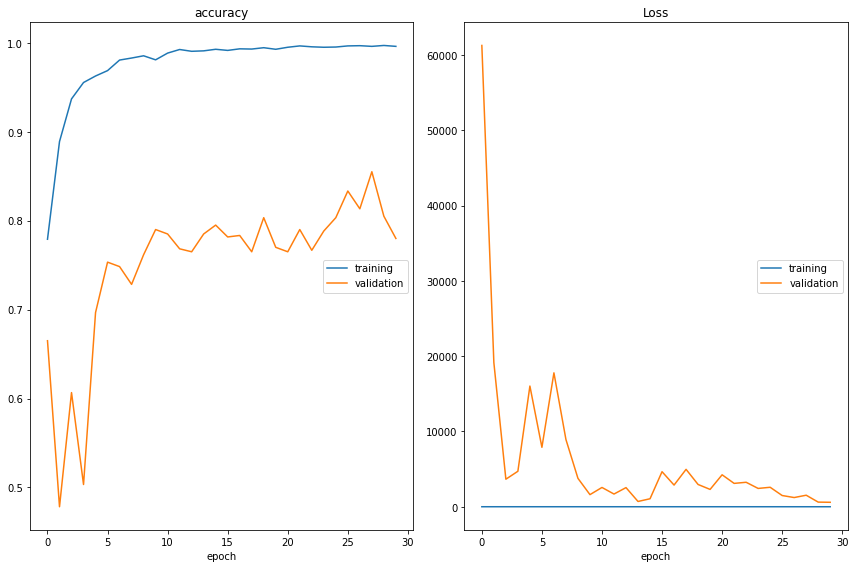

accuracy
	training         	 (min:    0.779, max:    0.997, cur:    0.996)
	validation       	 (min:    0.478, max:    0.855, cur:    0.780)
Loss
	training         	 (min:    0.010, max:    0.456, cur:    0.014)
	validation       	 (min:  590.856, max: 61257.105, cur:  590.856)


In [12]:
import warnings
warnings.filterwarnings("ignore")

# Training
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

#model.save_weights(MODEL_FILE)

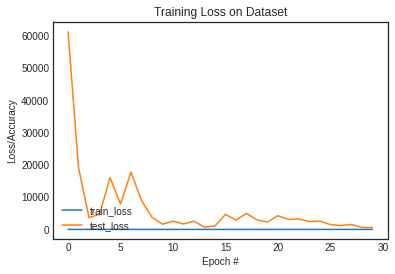

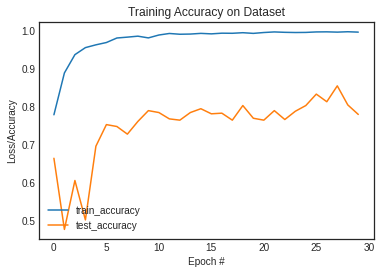

In [13]:

N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Found 600 images belonging to 2 classes.
Confusion Matrix


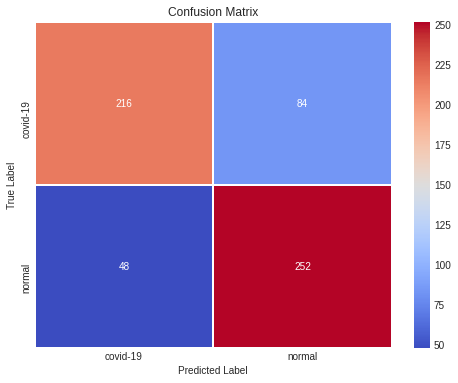

[[216  84]
 [ 48 252]]
Classification Report
              precision    recall  f1-score   support

    covid-19       0.82      0.72      0.77       300
      normal       0.75      0.84      0.79       300

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



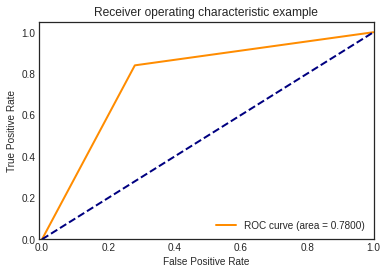

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)    

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [15]:
model.save("Inceptionresnet.h5")